In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, cv, Pool
import warnings
warnings.filterwarnings("ignore")

## **Загрузка данных**

In [ ]:
train_df = pd.read_parquet("/content/train_data.pqt")
test_df = pd.read_parquet("/content/test_data.pqt")

In [ ]:
train_df.head(3)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other}
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}",{other}


In [ ]:
test_df.head(3)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,None,...,0.010952,0.946066,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α}
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,None,...,0.006812,0.945281,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α}
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,None,...,0.006812,0.945281,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,None


## **Предобработка данных**

Определение списка категориальных признаков:

In [ ]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year"
]

Выделение числовых признаков:

In [ ]:
non_cat_cols = train_df.drop(cat_cols, axis=1)

### **Преобразование категориальных признаков**:
   - Приведение значений в категориальных признаках к типу данных "str" (строка) как в обучающем наборе данных train_df, так и в тестовом наборе данных test_df.
   - Для обучения модели, в дальнейшем категориальные признаки были преобразованы в тип "category" для корректной работы модели CatBoost.



In [ ]:
train_df[cat_cols] = train_df[cat_cols].astype("str")
test_df[cat_cols] = test_df[cat_cols].astype("str")

### **Создаем выборки для валидации и обучения**

 **Добавление данных за предыдущие месяцы**:
   - Мы прогнозируем переход в новый кластер только для 6 месяца, но в тествой выборке также присутсвует информация о двух предшествующих месяцах.
   - Возможно, целесообразно использовать эту информацию при построении прогноза
   - Для проверки полезности подобного хода, были созданы дополнительные столбцы, содержащие информацию за предыдущие два месяца(1 и 2).
   - В обучающей выборке эти данные были объединены с данными за последний месяц
   - Модель была обучена на новой выборке
   - Оказалось, что многие из добавленных столбцов имели достаточно высокий feature_importance
   - Также добавленные столбцы позволили снизить loss при обучении модели
   - Был построен прогноз на тестовой выборке
   - weighted roc_auc повысился вследствие предпинятых действий

Оставляем только 3 месяц, данные за 1 и 2 добаляем как новые столбцы

In [ ]:
# Фильтрация данных, оставляем только записи за последний месяц
last_month_df = train_df[train_df['date'] == 'month_3']

# Создание DataFrame для данных за предыдущие два месяца
prev_month_2_df = train_df[train_df['date'] == 'month_2'].set_index('id')
prev_month_1_df = train_df[train_df['date'] == 'month_1'].set_index('id')
prev_month_2_df[cat_cols] = prev_month_2_df[cat_cols].astype("category")
prev_month_1_df[cat_cols] = prev_month_1_df[cat_cols].astype("category")

# Переименование столбцов, чтобы избежать конфликтов имен
prev_month_2_df.columns = [f'{col}_prev_month_2' for col in prev_month_2_df.columns]
prev_month_1_df.columns = [f'{col}_prev_month_1' for col in prev_month_1_df.columns]

# Объединение данных за предыдущие месяцы
prev_months_combined = prev_month_2_df.join(prev_month_1_df, how='outer')

# Объединение данных за последний месяц с данными за предыдущие месяцы
final_df = last_month_df.set_index('id').join(prev_months_combined, how='left')

final_df

,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,...,cnt_cred_g_oper_3m_prev_month_1,cnt_days_cred_g_oper_3m_prev_month_1,sum_deb_h_oper_3m_prev_month_1,cnt_deb_h_oper_3m_prev_month_1,cnt_days_deb_h_oper_3m_prev_month_1,sum_cred_h_oper_3m_prev_month_1,cnt_cred_h_oper_3m_prev_month_1,cnt_days_cred_h_oper_3m_prev_month_1,start_cluster_prev_month_1,end_cluster_prev_month_1
id,,,,,,,,,,,,,,,,,,,,,
0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,...,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,month_3,-0.090605,-0.114275,-0.114119,-0.089937,channel_code_2,city_14,city_type_0,None,0.324343,...,0.945281,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},{other}
2,month_3,-0.148737,-0.187003,-0.112416,-0.148249,channel_code_12,city_613,city_type_306,None,-0.256297,...,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.178674,0.252657,0.440474,{α},{α}
3,month_3,-0.156522,-0.204718,-0.125759,-0.156058,channel_code_14,city_21,city_type_0,index_city_code_46,-1.185321,...,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,{α},{α}
4,month_3,-0.141798,-0.170262,-0.125672,-0.141289,channel_code_8,city_21,city_type_0,None,-1.417577,...,0.957443,0.672129,-0.078233,0.558209,0.707687,-0.178408,0.252946,0.440474,{α},{α}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,month_3,-0.039281,-0.053694,-0.044193,-0.038454,channel_code_9,city_20,city_type_0,index_city_code_28,1.601751,...,0.944497,0.384773,-0.161095,0.547319,0.429909,-0.201123,0.250924,0.374540,"{α, η}",{other}
199996,month_3,0.293117,0.189316,0.857952,0.294974,channel_code_14,city_3595,city_type_2778,index_city_code_48,-0.953065,...,0.944889,0.396267,-0.151699,0.553767,0.574354,-0.201123,0.250924,0.374540,"{α, γ}","{α, γ}"
199997,month_3,0.032941,0.140726,-0.125362,0.033992,channel_code_8,city_0,city_type_0,index_city_code_58,1.485623,...,0.944889,0.396267,1.185234,0.571535,0.918798,0.955885,0.264788,0.693221,{other},{other}


Преобразование столбцов с информацией о кластерах в категориальный тип данных

In [ ]:
# Функция для добавления новых слов в названия столбцов
def add_word(cols, suffix):
    return [col + suffix for col in cols]

# Добавление"_prev_month_2" и "_prev_month_1"
new_cat_cols = add_word(cat_cols, "_prev_month_2") + add_word(cat_cols, "_prev_month_1")
cat_cols += new_cat_cols

In [ ]:
final_df[cat_cols] = final_df[cat_cols].astype("category")

 ### **Удаление незначимых признаков**:
  - Изначальная спецификация была построена на всех признаках.
   - Был проведен анализ нулевой важности признаков и выявлены незначимые признаки(feature_importance=0).
   - Незначимые признаки были удалены из данных.
   - Упрощение модели упростило оптимизацию параметров и дало прирост в точности и производительности.

In [ ]:
zero_importance = ['city_type',
 'cnt_cred_d_oper_1m',
 'sum_deb_d_oper_3m',
 'cnt_deb_d_oper_3m',
 'sum_cred_d_oper_3m',
 'cnt_days_cred_f_oper_3m',
 'cnt_days_cred_g_oper_3m',
 'cnt_cred_h_oper_3m',
 'city_prev_month_2',
 'city_type_prev_month_2',
 'ogrn_days_end_quarter_prev_month_2',
 'sum_of_paym_2m_prev_month_2',
 'cnt_b_oper_1m_prev_month_2',
 'cnt_days_cred_f_oper_1m_prev_month_2',
 'cnt_deb_g_oper_1m_prev_month_2',
 'cnt_days_cred_g_oper_1m_prev_month_2',
 'cnt_deb_h_oper_1m_prev_month_2',
 'cnt_cred_h_oper_1m_prev_month_2',
 'cnt_days_cred_h_oper_1m_prev_month_2',
 'sum_b_oper_3m_prev_month_2',
 'sum_cred_d_oper_3m_prev_month_2',
 'cnt_cred_d_oper_3m_prev_month_2',
 'sum_cred_f_oper_3m_prev_month_2',
 'cnt_days_cred_f_oper_3m_prev_month_2',
 'cnt_deb_g_oper_3m_prev_month_2',
 'cnt_cred_g_oper_3m_prev_month_2',
 'city_type_prev_month_1',
 'sum_a_oper_1m_prev_month_1',
 'cnt_b_oper_1m_prev_month_1',
 'sum_cred_d_oper_1m_prev_month_1',
 'cnt_cred_e_oper_1m_prev_month_1',
 'cnt_days_deb_f_oper_1m_prev_month_1',
 'cnt_days_cred_f_oper_1m_prev_month_1',
 'cnt_deb_g_oper_1m_prev_month_1',
 'cnt_days_deb_g_oper_1m_prev_month_1',
 'sum_cred_g_oper_1m_prev_month_1',
 'cnt_days_cred_h_oper_1m_prev_month_1',
 'cnt_deb_d_oper_3m_prev_month_1',
 'sum_cred_d_oper_3m_prev_month_1',
 'cnt_cred_f_oper_3m_prev_month_1',
]

In [ ]:
cat_cols_to_remove = (list(set(zero_importance) & set(cat_cols)))
cat_cols_to_remove

['city_prev_month_2',
 'city_type_prev_month_1',
 'city_type_prev_month_2',
 'city_type']

In [ ]:
X = final_df.drop(["date", "end_cluster",'date_prev_month_1','date_prev_month_2','end_cluster_prev_month_1','end_cluster_prev_month_2'], axis=1)
X = X.drop(zero_importance, axis=1)
cat_cols = list(set(cat_cols).difference(cat_cols_to_remove))
y = final_df["end_cluster"]

## **Обучение модели**

В качестве базовой модели была выбрана Catboost и обучена на значимых признаках.

Зададим функцию для взвешенной метрики roc auc, которая вычисляет взвешенную площадь под ROC-кривой для многоклассовой классификации.

In [ ]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr")#, average=None)
    return sum(weights * classes_roc_auc)

 Загрузка весов кластеров из файла Excel и создание словаря weights_dict для использования в функции weighted_roc_auc

In [ ]:
cluster_weights = pd.read_excel("/content/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

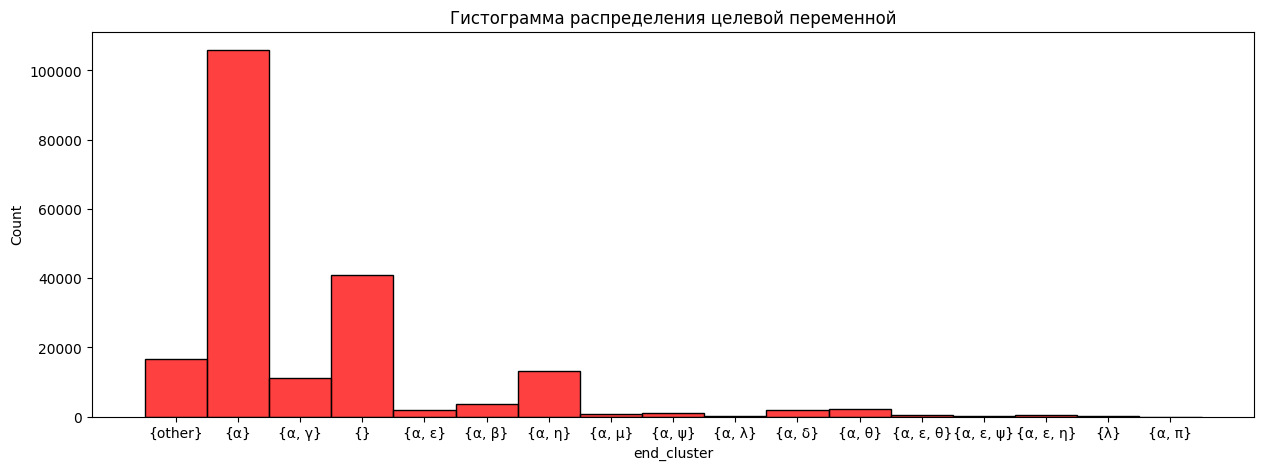

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(y, ax=ax, color='r')
plt.title('Гистограмма распределения целевой переменной')
plt.show()

Анализ гистограммы позволяет сделать вывод о преобладании класса alpha и класса {} в данных, что связано с распределением целевой переменной y. На гистограмме видно, что эти классы встречаются чаще других, что может привести к более высокому количеству ошибок при прогнозировании. Распределение классов не является равномерным, и класс {} и alpha можно выделить как мажоритарные. Для улучшения качества модели можно добавить в распределение больше наблюдений о минорных классах.  Для решения этой проблемы мы пробовали различные методы балансировки классов, такие как oversampling (увеличение числа примеров меньшего класса), что не привело к желаемым результатам.


После попыток исправить дисбаланс классов и подстроить модель к бизнес-задаче с использованием весов, а также при экспериментах с изменением характера распределения или корректировки функции потерь через class_weights, качество модели не улучшилось, а скорее ухудшилось. Даже применение техник over-sampling и under-sampling не привело к желаемым результатам.


**Обучение модели CatBoost на кросс-валидации**

По кросс-валидации мы определяли оптимальные параметры модели, теперь результаты меньше зависят от того, как мы разделим выборку.



In [ ]:
cv_dataset = Pool(data=X,
                  label=y,
                  cat_features=cat_cols)

In [ ]:
catboost_params = {
    'iterations': 1500,
    'learning_rate': 0.05,
    'depth': 7,
    'loss_function': 'MultiClass',
    'task_type': 'GPU',  # Включаем GPU
    'random_seed': 42,
    'early_stopping_rounds': 10,
    'verbose': 20
}

# Создаем CatBoost classifier
model0 = cv(cv_dataset, params=catboost_params, seed=42, fold_count=4, return_models=True)

Training on fold [0/4]
0:	learn: 2.4188895	test: 2.4198923	best: 2.4198923 (0)	total: 137ms	remaining: 3m 24s
20:	learn: 1.1444185	test: 1.1483589	best: 1.1483589 (20)	total: 1.59s	remaining: 1m 51s
40:	learn: 0.9401119	test: 0.9468476	best: 0.9468476 (40)	total: 4.24s	remaining: 2m 30s
60:	learn: 0.8727781	test: 0.8827498	best: 0.8827498 (60)	total: 5.82s	remaining: 2m 17s
80:	learn: 0.8450829	test: 0.8576327	best: 0.8576327 (80)	total: 7.31s	remaining: 2m 8s
100:	learn: 0.8313523	test: 0.8461125	best: 0.8461125 (100)	total: 8.71s	remaining: 2m
120:	learn: 0.8213876	test: 0.8385687	best: 0.8385687 (120)	total: 10.2s	remaining: 1m 55s
140:	learn: 0.8141595	test: 0.8337448	best: 0.8337448 (140)	total: 11.6s	remaining: 1m 51s
160:	learn: 0.8074076	test: 0.8294710	best: 0.8294710 (160)	total: 13.1s	remaining: 1m 48s
180:	learn: 0.8023898	test: 0.8267354	best: 0.8267354 (180)	total: 14.7s	remaining: 1m 46s
200:	learn: 0.7975659	test: 0.8241829	best: 0.8241829 (200)	total: 16.9s	remaining: 

Оптимальные параметры:

In [ ]:
catboost_params = {
    'iterations': 965,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'MultiClass',
    'task_type': 'GPU',  # Включаем GPU
    'random_seed': 42
}

In [ ]:
model0 = CatBoostClassifier(**catboost_params)

In [ ]:
model0.fit(X, y, cat_features=cat_cols, verbose=10)

0:	learn: 2.4239728	total: 79.6ms	remaining: 1m 16s
10:	learn: 1.4333047	total: 602ms	remaining: 52.2s
20:	learn: 1.1559767	total: 1.06s	remaining: 47.6s
30:	learn: 1.0245511	total: 1.54s	remaining: 46.4s
40:	learn: 0.9530675	total: 2.03s	remaining: 45.7s
50:	learn: 0.9102604	total: 2.5s	remaining: 44.8s
60:	learn: 0.8851955	total: 2.98s	remaining: 44.1s
70:	learn: 0.8687502	total: 3.46s	remaining: 43.6s
80:	learn: 0.8576248	total: 3.94s	remaining: 43s
90:	learn: 0.8493206	total: 4.41s	remaining: 42.3s
100:	learn: 0.8430420	total: 4.86s	remaining: 41.6s
110:	learn: 0.8380930	total: 5.34s	remaining: 41.1s
120:	learn: 0.8339159	total: 5.81s	remaining: 40.5s
130:	learn: 0.8301843	total: 6.25s	remaining: 39.8s
140:	learn: 0.8271987	total: 6.7s	remaining: 39.2s
150:	learn: 0.8238974	total: 7.16s	remaining: 38.6s
160:	learn: 0.8214903	total: 7.62s	remaining: 38s
170:	learn: 0.8186597	total: 8.09s	remaining: 37.6s
180:	learn: 0.8162807	total: 8.55s	remaining: 37s
190:	learn: 0.8143620	total: 

In [ ]:
# Сохранение модели в файл
model0.save_model('catboost_model_base.bin')

In [ ]:
y_pred_proba_train0 = model0.predict_proba(X)
weighted_roc_auc(y, y_pred_proba_train0, model0.classes_, weights_dict)

0.9502439722629902

**Визуализация матрицы ошибок (Confusion Matrix) для базовой модели CatBoost**

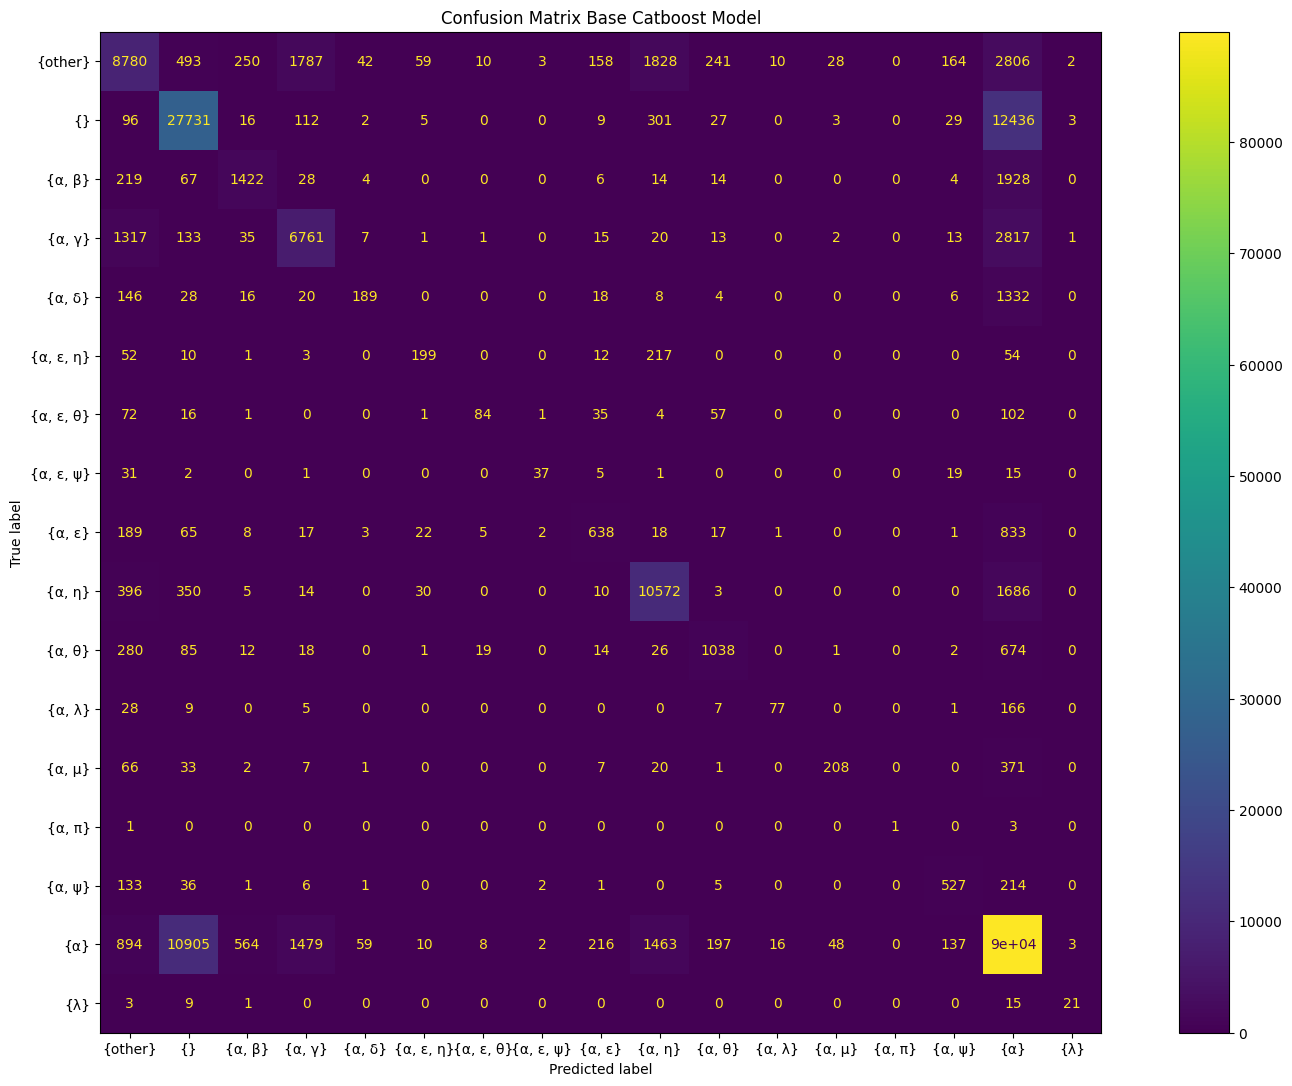

In [ ]:
preds0 = model0.predict(X)
figure, ax = plt.subplots(figsize=(20, 13))
ConfusionMatrixDisplay.from_predictions(y, preds0, ax=ax)
plt.title('Confusion Matrix Base Catboost Model')
plt.show()

#### Анализируя confusion matrix, можно сделать вывод о том, что основная часть ошибок сосредоточена в классах alpha и other. Это обусловлено тем, что в этих классов больше всего в данных, что усложняет задачу модели в правильной классификации. Такая неравномерность распределения данных приводит к снижению точности предсказаний. Также, по смыслу other, скорее всего, включает в себя несколько разных совокупностей, что делает классификацию затруднительной из-за неоднородности отличительных признаков класса.


Вычисление и визуализация важности признаков для базовой модели CatBoost

In [ ]:
feature_importances = pd.DataFrame(zip(X.columns, model0.feature_importances_))
feature_importances.columns = ['feature name', 'importance']
feature_importances

,feature name,importance
0,balance_amt_avg,1.333160
1,balance_amt_max,1.835495
2,balance_amt_min,2.721248
3,balance_amt_day_avg,1.385069
4,channel_code,1.651548
...,...,...
225,cnt_days_deb_h_oper_3m_prev_month_1,0.163537
226,sum_cred_h_oper_3m_prev_month_1,0.260966
227,cnt_cred_h_oper_3m_prev_month_1,0.130765
228,cnt_days_cred_h_oper_3m_prev_month_1,0.161172


Выделяем подмножество наиболее важных признаков, которые имеют значение важности больше 1.

In [ ]:
very_important = feature_importances[feature_importances['importance'] > 1].sort_values(by='importance', ascending=False)

 **Отображение наиболее важных признаков**

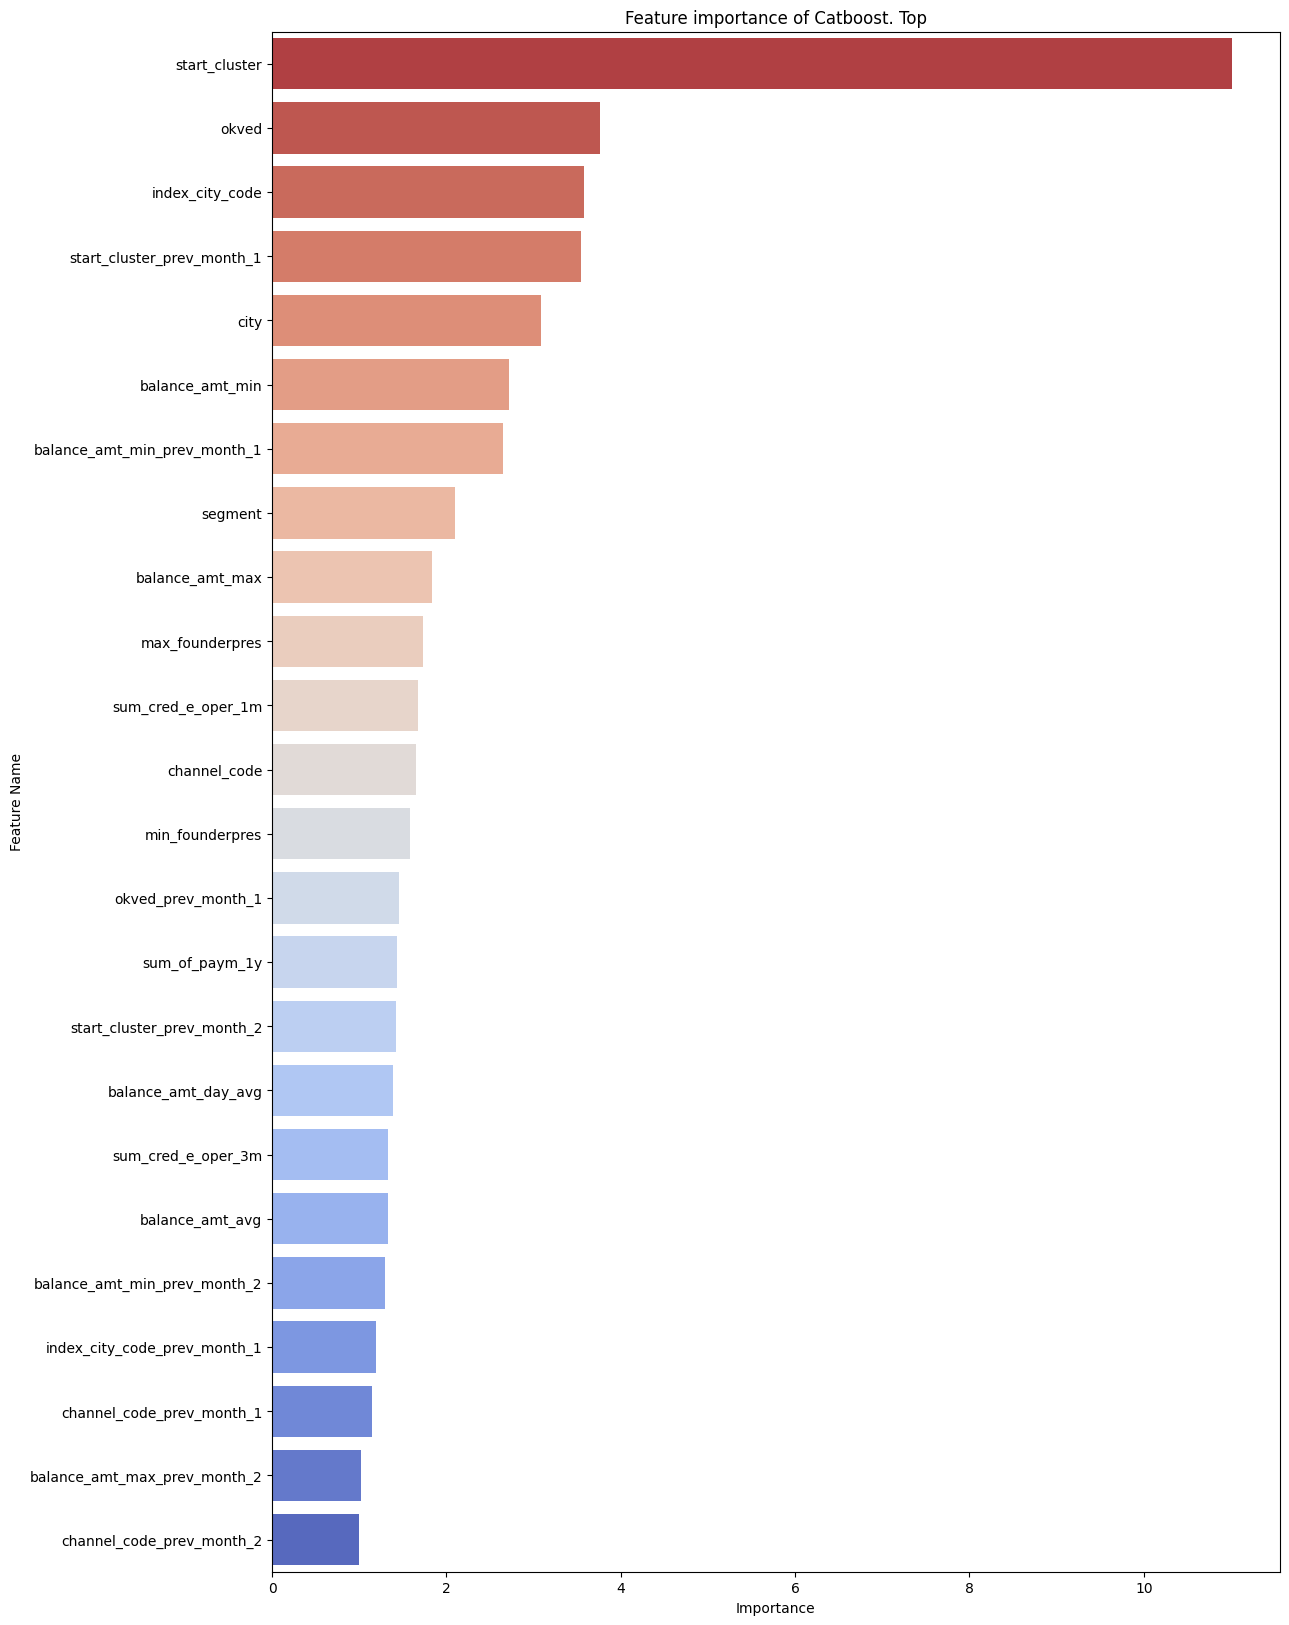

In [ ]:
figure, ax = plt.subplots(figsize=(13, 20))
palette = sns.color_palette("coolwarm", len(very_important))
palette = np.array(palette[::-1] * (len(very_important) // len(palette) + 1))

sns.barplot(x=very_important['importance'], y=very_important['feature name'], ax=ax,
            palette=palette)
plt.title('Feature importance of Catboost. Top')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.show()

In [ ]:
import shap
explainer = shap.Explainer(model0)
# shap_values = explainer(X)

In [ ]:
shap_values = explainer(X.loc[:1000, :])

In [ ]:
shap_values.data

array([[0.6926532872780727, 0.7402527649248496, 0.4300415771882157, ...,
        0.2959842823237963, 0.9679467122539559, '{α, γ}'],
       [-0.09060494925343959, -0.11427473969071136, -0.11411871447326823,
        ..., 0.2535232771244895, 0.4624522067594504, '{other}'],
       [-0.14873701973478415, -0.1870030142642037, -0.11241585687937147,
        ..., 0.25265672599797306, 0.4404741847814284, '{α}'],
       ...,
       [-0.12398459672632266, -0.15905273795085087, -0.1121250913590023,
        ..., 0.266232693646731, 0.6822324265396702, '{α}'],
       [-0.15667908707294007, -0.2048881081949622, -0.12574923589800915,
        ..., 0.2512124741204456, 0.3855291298363735, '{α}'],
       [0.8807408339967648, 0.5841267325210396, 2.449561292746788, ...,
        0.2512124741204456, 0.3855291298363735, '{α}']], dtype=object)

In [ ]:
model0.classes_

array(['{other}', '{}', '{α, β}', '{α, γ}', '{α, δ}', '{α, ε, η}',
       '{α, ε, θ}', '{α, ε, ψ}', '{α, ε}', '{α, η}', '{α, θ}', '{α, λ}',
       '{α, μ}', '{α, π}', '{α, ψ}', '{α}', '{λ}'], dtype=object)

In [ ]:
shap_values[1].shape

(230, 17)

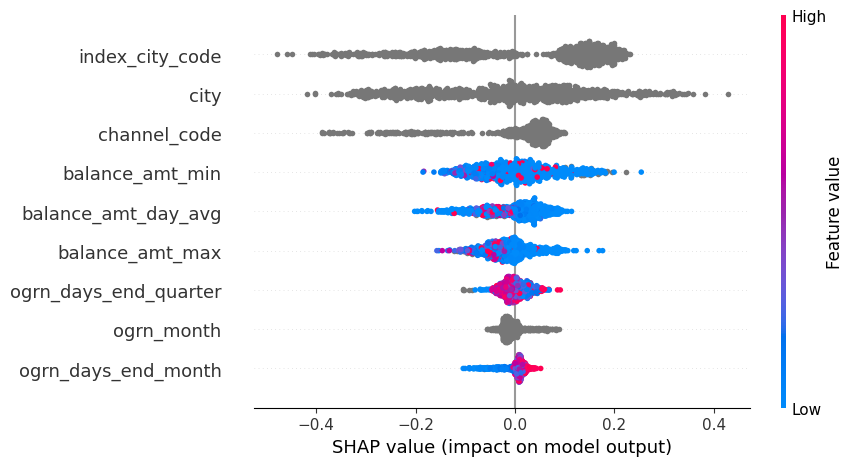

In [ ]:
shap.plots.beeswarm(shap_values[:, [2, 3, 7, 8, 11, 14, 17, 18, 19, 20], -3])

In [ ]:
catboost_params = {
    'iterations': 1500,
    'depth': 6,
    'loss_function': 'MultiClass',
    'task_type': 'GPU',  # Включаем GPU
    'random_seed': 42,
    'learning_rate': 0.05,
    'early_stopping_rounds': 15,
    'verbose': 100
}

# Создаем CatBoost classifier
model0 = cv(cv_dataset, params=catboost_params, seed=42, fold_count=15, return_models=True)

In [ ]:
for i in range(len(model0[1])):
    model0[1][i].save_model(f'model_{i}', format='cbm')

In [ ]:
models = [CatBoostClassifier().load_model(f'/kaggle/working/model_{i}') for i in range(15)]

In [ ]:
res = np.mean([models[i].predict_proba(X) for i in range(len(models))], axis=0)
res

In [ ]:
weighted_roc_auc(y, res, models[0].classes_, weights_dict)

## **Прогноз на тестовой выборке**

In [ ]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year"
]

**Фильтрация данных и объединение таблиц:**
   - Из тестовой выборки выделяются записи за последний месяц 'month_6' в last_month_df.
   - Создаются DataFrame для данных за предыдущие два месяца 'month_5' и 'month_4' в prev_month_5_df и prev_month_4_df.
   - Столбцы с категориальными признаками приводятся к типу 'category'.
   - Столбцы переименовываются, чтобы избежать конфликтов имен.
   - Данные за предыдущие месяцы объединяются в prev_months_combined.
   - Данные за последний месяц объединяются с данными за предыдущие месяцы в final_df.

In [ ]:
# Фильтрация данных, оставляем только записи за последний месяц
last_month_df = test_df[test_df['date'] == 'month_6']

# Создание DataFrame для данных за предыдущие два месяца
prev_month_5_df = test_df[test_df['date'] == 'month_5'].set_index('id')
prev_month_4_df = test_df[test_df['date'] == 'month_4'].set_index('id')
prev_month_5_df[cat_cols] = prev_month_5_df[cat_cols].astype("category")
prev_month_4_df[cat_cols] = prev_month_4_df[cat_cols].astype("category")

# Переименование столбцов, чтобы избежать конфликтов имен
prev_month_5_df.columns = [f'{col}_prev_month_2' for col in prev_month_5_df.columns]
prev_month_4_df.columns = [f'{col}_prev_month_1' for col in prev_month_4_df.columns]

# Объединение данных за предыдущие месяцы
prev_months_combined = prev_month_5_df.join(prev_month_4_df, how='outer')

# Объединение данных за последний месяц с данными за предыдущие месяцы
final_df = last_month_df.set_index('id').join(prev_months_combined, how='left')

# Вывод результата
final_df


In [ ]:
test_df.pivot(index="id", columns="date", values="start_cluster").head(3)

**Заполнение стартового кластера:**

Для того, чтобы сделать прогноз на тестовой выборке, нужно заполнить стартовый кластер. </br>


Проверим, насаколько часто стартовый кластер меняется за один месяц

In [ ]:
sum(train_df[train_df['date'] == 'month_1']['start_cluster'].values != train_df[train_df['date'] == 'month_2']['start_cluster'].values) / len(train_df[train_df['date']=='month_2'])

В обучающей выборке стартовый кластер изменяется между первым и вторым месяцами в 9% случаев

In [ ]:
sum(train_df[train_df['date'] == 'month_2']['start_cluster'].values != train_df[train_df['date'] == 'month_3']['start_cluster'].values) / len(train_df[train_df['date']=='month_3'])

Между 2 и 3 месяцами в 11% случаев

In [ ]:
len(test_df[test_df['date'] == 'month_4']), len(test_df[test_df['date'] == 'month_5'])

В тестовой выборке 90120 записей о 4 месяце и 100000 записей о 5 месяце

In [ ]:
t_month_4 = test_df[test_df['date']=='month_4'].set_index('id').index

In [ ]:
t_month_5 = test_df[test_df['date'] == 'month_5'].set_index('id').index

In [ ]:
index = t_month_4.intersection(t_month_5)

In [ ]:
# Данные о клиентах, имеющих записи и за 4 и за 5 месяца
t = test_df.set_index('id').loc[index]

In [ ]:
sum(t[t['date'] == 'month_4']['start_cluster'].values != t[t['date'] == 'month_5']['start_cluster'].values) / len(test_df[test_df['date']=='month_5'])

Получается, 6% клиентов поменяли свой стартовый кластер с 4 на 5 месяц

На основании достаточно низкого процента клиентов, меняющих свой кластер от месяца к месяцу, было принято решение заменить значение start_cluster в шестом месяце значением start_cluster за пятый месяц.

Также были предприняты попытки построить модель, которая предсказывала бы переход клиента в другой начальный кластер в следующем месяце. Но данная модель показала худший результат по сравнению с простой заменой занчения start cluster на значение из предыдущего месяца. Значение ошибки варьировалось от 18% до 20%.

In [ ]:
filtered_rows = test_df[test_df['date'] == 'month_5']
start_cluster_column = filtered_rows['start_cluster']

# Вывод результатов
print(start_cluster_column)

In [ ]:
sample_submission_df = pd.read_csv("/kaggle/input/alphadataset/sample_submission.csv")

In [ ]:
sample_submission_df.shape

In [ ]:
sample_submission_df.head()

Для тестовой выборки будем использовать только последний месяц

### **Подготовка данных для прогноза:**
   - стартовый кластер заполняется значением за 5 месяц
   - Удаляются незначимые признаки
   - Пропуски в категориальных столбцах заполняются значением "None".

In [ ]:
final_df = final_df.drop(["date",'date_prev_month_1','date_prev_month_2'], axis=1)
final_df.drop("start_cluster", axis=1)
final_df["start_cluster"] = start_cluster_column.values
final_df["start_cluster"] = final_df["start_cluster"].astype("category")
final_df["start_cluster"]

In [ ]:
final_df

In [ ]:
# Функция для добавления новых слов в названия столбцов
def add_word(cols, suffix):
    return [col + suffix for col in cols]

# Добавление"_prev_month_2" и "_prev_month_1"
new_cat_cols = add_word(cat_cols, "_prev_month_2") + add_word(cat_cols, "_prev_month_1")
cat_cols += new_cat_cols

In [ ]:
clusters = ['start_cluster_prev_month_1','start_cluster_prev_month_2']
final_df[clusters] = final_df[clusters].astype('category')
final_df['start_cluster_prev_month_1'] = final_df['start_cluster_prev_month_1'].cat.add_categories(["None"])
final_df['start_cluster_prev_month_2'] = final_df['start_cluster_prev_month_2'].cat.add_categories(["None"])

In [ ]:
final_df[new_cat_cols]

In [ ]:
final_df = final_df.drop(zero_importance, axis=1)
cat_cols = list(set(cat_cols).difference(cat_cols_to_remove))

In [ ]:
final_df[cat_cols]

In [ ]:
final_df[cat_cols] = final_df[cat_cols].fillna("None",axis=1)

In [ ]:
final_df

### **Прогноз с помощью модели:**


In [ ]:
test_pred_proba = np.mean([models[i].predict_proba(final_df) for i in range(len(models))], axis=0)
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=models[0].classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

In [ ]:
test_pred_proba_df.shape

In [ ]:
test_pred_proba_df.head(2)

### **Создание файла с прогнозом:**

In [ ]:
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("submission_final.csv", index=False)

In [ ]:
sample_submission_df